In [122]:
import numpy as np
import re
import pickle
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure
from PIL import Image
import requests
from io import BytesIO
import os
import seaborn as sns
from scipy import sparse
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

In [123]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

This data list has all the product related information like length of the dress, neckline, sleeve type etc.,

In [124]:
all_product_data_list = pd.read_csv('products.csv')
all_product_data_list.head()

,product_id,designer_name,displayName,length,neckline,productDetails,retailPrice,season,sleeve,stylistNotes,price_base,price_adjusted,ageRanges_teens,ageRanges_early_twenties,ageRanges_late_twenties,ageRanges_thirties,ageRanges_forties_plus,bodyTypes_apple,bodyTypes_athletic,bodyTypes_full_bust,bodyTypes_hourglass,bodyTypes_pear,bodyTypes_petite,bodyTypes_straight_narrow,bodyTypes_bump_friendly,colors_green,colors_white,colors_print,colors_multicolored,colors_blue,colors_cream,colors_black,colors_pink,colors_red,colors_brown,colors_yellow,colors_orange,colors_purple,colors_gold,colors_grey,colors_silver,colors_crystal_clear,colors_pearl,occasions_wedding,occasions_party,occasions_vacation,occasions_weekend,occasions_date,occasions_work,occasions_formal_affair,embellishments_florals,embellishments_cut_outs,embellishments_color_block,embellishments_abstract_prints,embellishments_maxis,embellishments_pastels,embellishments_lace,embellishments_pockets,embellishments_metallics,embellishments_peplum,embellishments_sequins,embellishments_beaded,product_img_link
0,CRCR18,Cara Cara New York,Juju Dress,tea_length,square,<p>White floral (100% Cotton Poplin). Casual d...,USD 525.00,spring_summer,sleeveless,<p>This Cara Cara New York dress features a ch...,50.0,50.0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...
1,ADAMC171,Adam Lippes Collective,Floral Pleated Midi Dress,tea_length,square,"<p>Chiffon (97% Cotton, 3% Spandex). Casual Dr...",USD 445.00,spring_summer,sleeveless,<p>The Floral Pleated Midi Dress by Adam Lippe...,40.0,40.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...
2,MDW381,Madewell,Bianca Dress,tea_length,sweetheart,<p>Blue striped (100% Cotton). Casual dress. S...,USD 138.00,spring_summer,sleeveless,<p>This breezy blue and white striped midi dre...,30.0,30.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...
3,SRUE1,Rue Sophie,Eli Dress,tea_length,square,"<p>Off-white (67% Rayon, 26% Nylon, 7% Spandex...",USD 188.00,spring_summer,sleeveless,<p>This Sophie Rue white midi dress offers a t...,30.0,30.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...
4,ALC289,A.L.C.,Alexandria Midi Dress,tea_length,v_neck,<p>White (100% Cotton). Casual dress. Cap slee...,USD 495.00,spring_summer,cap_sleeve,<p>This A.L.C. white dress features a twist-fr...,45.0,45.0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...


# Preprocessing

In [125]:
review_data = pd.read_csv('reviews.csv')
review_data.head()

,product_id,averageRating,countRatings,currentCount,user_id,bodyType,bustSize,numReviewsByUser,height,heightInches,standardSize,usStandardSize,weight,weightPounds,caption,content,fit,rating,reviewId,uploadedAt,product_img_link
0,CRCR18,7.0,3,3,21194830,Hourglass,36C,95,NaN,70.0,NaN,10.0,NaN,162.0,Feminine fit,This was a pretty dress. I brought it on vacat...,True to Size,8,2939989,"Apr 08, 2024 9:10:51 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
1,CRCR18,7.0,3,3,19471194,Hourglass,NaN,24,NaN,64.0,NaN,2.0,NaN,110.0,Team RTR Review,"A beautiful, easy vacation dress! Unfortunatel...",Large,8,2927834,"Mar 25, 2024 7:28:00 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
2,CRCR18,7.0,3,3,11604948,Hourglass,32DD,3,NaN,68.0,NaN,4.0,NaN,135.0,Cute but didn’t wear,NaN,True to Size,6,2933106,"Apr 01, 2024 6:39:47 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
3,ADAMC171,9.0,3,3,22091421,Straight & narrow,34C,77,NaN,65.0,NaN,2.0,NaN,125.0,RTR Team Review,Loved this flowy and feminine dress from Adam ...,True to Size,10,2933881,"Apr 02, 2024 4:15:40 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
4,ADAMC171,9.0,3,3,22164997,Petite,32A,17,NaN,70.0,NaN,2.0,NaN,120.0,Lovely,"Gorgeous dress, fits and feels great, extremel...",True to Size,10,2940474,"Apr 09, 2024 2:18:33 PM",https://pc-ap.rtrcdn.com/productimages/front/1...


In [126]:
review_data.shape

(249271, 21)

### Drop some fields

In [127]:
review_data.drop(columns = ['currentCount', 'height', 'standardSize', 'weight'], inplace = True)

In [128]:
review_data.describe()

,averageRating,countRatings,user_id,numReviewsByUser,heightInches,usStandardSize,weightPounds,rating,reviewId
count,249271.000000,249271.000000,2.492710e+05,249271.000000,246855.000000,248027.000000,2.169420e+05,249271.000000,2.492710e+05
mean,8.308227,65.095258,1.601754e+07,40.897445,65.350072,6.420470,1.544335e+05,8.677897,2.602475e+06
std,0.884483,116.723146,6.811039e+06,97.165352,2.669056,3.997845,1.172168e+07,2.163762,2.842033e+05
min,0.000000,0.000000,1.000174e+06,1.000000,54.000000,0.000000,0.000000e+00,0.000000,8.724000e+03
25%,8.000000,29.000000,1.067240e+07,4.000000,63.000000,4.000000,1.270000e+02,8.000000,2.449318e+06
50%,8.000000,46.000000,1.828603e+07,11.000000,65.000000,6.000000,1.400000e+02,10.000000,2.678887e+06
75%,9.000000,75.000000,2.188341e+07,33.000000,67.000000,8.000000,1.550000e+02,10.000000,2.820207e+06
max,10.000000,4632.000000,2.361793e+07,1302.000000,124.000000,22.000000,1.701651e+09,10.000000,2.945185e+06


## Fix variable types

### Numeric Data

In [129]:
review_data = review_data.astype({'numReviewsByUser': 'int',
                                  'rating': 'int', 
                                  'heightInches': 'float',
                                  'weightPounds': 'float'})

### US Standard Size

In [130]:
review_data['usStandardSize'].unique(), review_data['usStandardSize'].dtype

(array([10.,  2.,  4.,  6., 18., 12.,  8.,  0., 14., 16., nan, 20., 22.]),
 dtype('float64'))

In [131]:
review_data.head()

,product_id,averageRating,countRatings,user_id,bodyType,bustSize,numReviewsByUser,heightInches,usStandardSize,weightPounds,caption,content,fit,rating,reviewId,uploadedAt,product_img_link
0,CRCR18,7.0,3,21194830,Hourglass,36C,95,70.0,10.0,162.0,Feminine fit,This was a pretty dress. I brought it on vacat...,True to Size,8,2939989,"Apr 08, 2024 9:10:51 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
1,CRCR18,7.0,3,19471194,Hourglass,NaN,24,64.0,2.0,110.0,Team RTR Review,"A beautiful, easy vacation dress! Unfortunatel...",Large,8,2927834,"Mar 25, 2024 7:28:00 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
2,CRCR18,7.0,3,11604948,Hourglass,32DD,3,68.0,4.0,135.0,Cute but didn’t wear,NaN,True to Size,6,2933106,"Apr 01, 2024 6:39:47 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
3,ADAMC171,9.0,3,22091421,Straight & narrow,34C,77,65.0,2.0,125.0,RTR Team Review,Loved this flowy and feminine dress from Adam ...,True to Size,10,2933881,"Apr 02, 2024 4:15:40 PM",https://pc-ap.rtrcdn.com/productimages/front/1...
4,ADAMC171,9.0,3,22164997,Petite,32A,17,70.0,2.0,120.0,Lovely,"Gorgeous dress, fits and feels great, extremel...",True to Size,10,2940474,"Apr 09, 2024 2:18:33 PM",https://pc-ap.rtrcdn.com/productimages/front/1...


### Date Time

In [132]:
review_data['uploadedAt'].dtype

dtype('O')

In [133]:
review_data['uploadedAt'] = pd.to_datetime(review_data['uploadedAt'])

In [134]:
review_data.head()

,product_id,averageRating,countRatings,user_id,bodyType,bustSize,numReviewsByUser,heightInches,usStandardSize,weightPounds,caption,content,fit,rating,reviewId,uploadedAt,product_img_link
0,CRCR18,7.0,3,21194830,Hourglass,36C,95,70.0,10.0,162.0,Feminine fit,This was a pretty dress. I brought it on vacat...,True to Size,8,2939989,2024-04-08 21:10:51,https://pc-ap.rtrcdn.com/productimages/front/1...
1,CRCR18,7.0,3,19471194,Hourglass,NaN,24,64.0,2.0,110.0,Team RTR Review,"A beautiful, easy vacation dress! Unfortunatel...",Large,8,2927834,2024-03-25 19:28:00,https://pc-ap.rtrcdn.com/productimages/front/1...
2,CRCR18,7.0,3,11604948,Hourglass,32DD,3,68.0,4.0,135.0,Cute but didn’t wear,NaN,True to Size,6,2933106,2024-04-01 18:39:47,https://pc-ap.rtrcdn.com/productimages/front/1...
3,ADAMC171,9.0,3,22091421,Straight & narrow,34C,77,65.0,2.0,125.0,RTR Team Review,Loved this flowy and feminine dress from Adam ...,True to Size,10,2933881,2024-04-02 16:15:40,https://pc-ap.rtrcdn.com/productimages/front/1...
4,ADAMC171,9.0,3,22164997,Petite,32A,17,70.0,2.0,120.0,Lovely,"Gorgeous dress, fits and feels great, extremel...",True to Size,10,2940474,2024-04-09 14:18:33,https://pc-ap.rtrcdn.com/productimages/front/1...


### Bust data - We will split this to hold the bist size and cup size separately

In [135]:
review_data['bustSize'].unique()

array(['36C', nan, '32DD', '34C', '32A', '34B', '36A', '38DDD/E', '34D',
       '36B', '32B', '32C', '34A', '36D', '36DD', '32D', '28AA', '40C',
       '38H', '28DD', '34DD', '40DDD/E', '34DDD/E', '40G', '32DDD/E',
       '42D', '38C', '38D', '36DDD/E', '38B', '40B', '28C', '32G', '34I',
       '40D', '38DD', '34D+', '30D', '34F', '30B', '28A', '42C', '30DD',
       '38G', '36G', '30A', '40DD', '28DDD/E', '30G', '36AA', '36I',
       '38A', '36H', '36J', '34G', '30DDD/E', '36F', '32H', '28B', '38F',
       '28D', '30C', '32F', '32AA', '40H', '34H', '30AA', '42G', '30F',
       '44G', '34AA', '42DDD/E', '28G', '44DDD/E', '44DD', '40A', '42DD',
       '30H', '34J', '40F', '42H', '32J', '38J', '38I', '42B', '38AA',
       '36D+', '42F', '46D', '32I', '44C', '32D+', '30J', '40AA', '44H',
       '28H', '46C', '46DDD/E', '46DD', '44F', '28F', '44D', '48DD',
       '42I', '48J', '28J', '38D+', '44AA', '50B', '42J', '46H', '44B',
       '40I', '40J', '44J', '42A', '48DDD/E', '28I', '48G'], dty

In [136]:
bust_data = review_data['bustSize'].str.extract('([^a-zA-Z]+)([a-zA-Z]+)', expand=True)
bust_data.columns = ['bust_size', 'bust_type']
review_data = review_data.join(bust_data)
review_data = review_data.astype({'bust_size': 'float'})
review_data = review_data.drop(columns=['bustSize'])

In [137]:
review_data.head()

,product_id,averageRating,countRatings,user_id,bodyType,numReviewsByUser,heightInches,usStandardSize,weightPounds,caption,content,fit,rating,reviewId,uploadedAt,product_img_link,bust_size,bust_type
0,CRCR18,7.0,3,21194830,Hourglass,95,70.0,10.0,162.0,Feminine fit,This was a pretty dress. I brought it on vacat...,True to Size,8,2939989,2024-04-08 21:10:51,https://pc-ap.rtrcdn.com/productimages/front/1...,36.0,C
1,CRCR18,7.0,3,19471194,Hourglass,24,64.0,2.0,110.0,Team RTR Review,"A beautiful, easy vacation dress! Unfortunatel...",Large,8,2927834,2024-03-25 19:28:00,https://pc-ap.rtrcdn.com/productimages/front/1...,NaN,NaN
2,CRCR18,7.0,3,11604948,Hourglass,3,68.0,4.0,135.0,Cute but didn’t wear,NaN,True to Size,6,2933106,2024-04-01 18:39:47,https://pc-ap.rtrcdn.com/productimages/front/1...,32.0,DD
3,ADAMC171,9.0,3,22091421,Straight & narrow,77,65.0,2.0,125.0,RTR Team Review,Loved this flowy and feminine dress from Adam ...,True to Size,10,2933881,2024-04-02 16:15:40,https://pc-ap.rtrcdn.com/productimages/front/1...,34.0,C
4,ADAMC171,9.0,3,22164997,Petite,17,70.0,2.0,120.0,Lovely,"Gorgeous dress, fits and feels great, extremel...",True to Size,10,2940474,2024-04-09 14:18:33,https://pc-ap.rtrcdn.com/productimages/front/1...,32.0,A


## Missing Values

In [138]:
review_data.isnull().sum()

product_id              0
averageRating           0
countRatings            0
user_id                 0
bodyType             6258
numReviewsByUser        0
heightInches         2416
usStandardSize       1244
weightPounds        32329
caption               263
content             25064
fit                 12755
rating                  0
reviewId                0
uploadedAt              0
product_img_link        0
bust_size           32818
bust_type           32818
dtype: int64

### Numeric

In [139]:
print(review_data['heightInches'].mean(), review_data['heightInches'].median())
review_data['heightInches'].fillna(review_data['heightInches'].median(), inplace = True)

65.35007190455936 65.0


<Axes: >

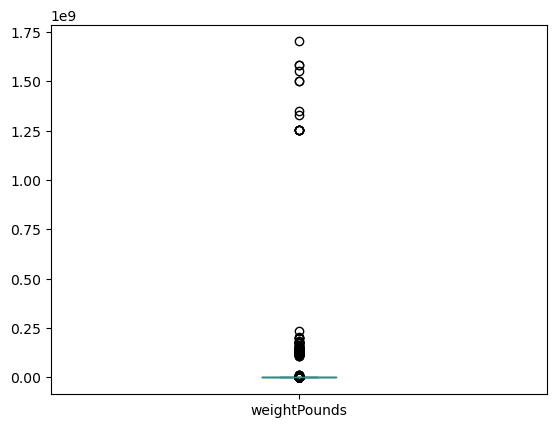

In [140]:
review_data['weightPounds'].plot.box()

In [141]:
print(review_data['weightPounds'].mean(), review_data['weightPounds'].median())
review_data['weightPounds'].fillna(review_data['weightPounds'].median(), inplace = True)

154433.54480460216 140.0


### Categorical

In [142]:
print(review_data['bodyType'].value_counts())
review_data['bodyType'].fillna(review_data['bodyType'].value_counts().index[0], inplace = True)

Hourglass            73393
Athletic             61110
Pear                 29667
Petite               28074
Straight & narrow    20850
Full Bust            20670
Apple                 9249
Name: bodyType, dtype: int64


In [143]:
print(review_data['bust_size'].value_counts())
review_data['bust_size'].fillna(review_data['bust_size'].value_counts().index[0], inplace = True)

34.0    91128
36.0    53163
32.0    47818
38.0    14948
30.0     4264
40.0     2351
28.0     1883
42.0      652
44.0      200
46.0       37
48.0        8
50.0        1
Name: bust_size, dtype: int64


In [144]:
print(review_data['bust_type'].value_counts())

types = ['C', 'B']
idx = review_data.loc[review_data['bust_type'].isna() == True].index

for i in idx:
    pos = random.randint(0,1)
    review_data['bust_type'].iloc[i] = types[pos]


C      58359
B      55095
D      39555
DD     28341
A      17080
DDD    10796
G       2639
F       2082
AA      1257
H        829
I        210
J        210
Name: bust_type, dtype: int64


/var/folders/rx/0lw0w5ds7t36p51ggtr6fdr80000gn/T/ipykernel_95896/2200703993.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['bust_type'].iloc[i] = types[pos]


In [145]:
review_data['bust_type'].value_counts()

C      74823
B      71449
D      39555
DD     28341
A      17080
DDD    10796
G       2639
F       2082
AA      1257
H        829
I        210
J        210
Name: bust_type, dtype: int64

In [146]:
print(review_data['usStandardSize'].value_counts())
review_data['usStandardSize'].fillna(review_data['usStandardSize'].value_counts().index[0], inplace = True)

4.0     53525
6.0     47643
8.0     36215
2.0     31177
10.0    26204
12.0    18848
0.0     17666
14.0    10310
16.0     4651
18.0     1308
20.0      329
22.0      151
Name: usStandardSize, dtype: int64


In [147]:
print(review_data['fit'].value_counts())
review_data['fit'].fillna(review_data['fit'].value_counts().index[0], inplace = True)

True to Size    180792
Large            30289
Small            25435
Name: fit, dtype: int64


### Remaining values

In [148]:
review_data.isnull().sum()

product_id              0
averageRating           0
countRatings            0
user_id                 0
bodyType                0
numReviewsByUser        0
heightInches            0
usStandardSize          0
weightPounds            0
caption               263
content             25064
fit                     0
rating                  0
reviewId                0
uploadedAt              0
product_img_link        0
bust_size               0
bust_type               0
dtype: int64

# EDA

In [149]:
# Unique users
print("No. of users:", review_data['user_id'].nunique())

No. of users: 102988


In [150]:
# Unique products
print("No. of products:", review_data['product_id'].nunique())

No. of products: 9105


In [151]:
# Time period
print("From", review_data['uploadedAt'].min(), "to", review_data['uploadedAt'].max())

From 2011-02-23 22:06:37 to 2024-04-15 03:28:56


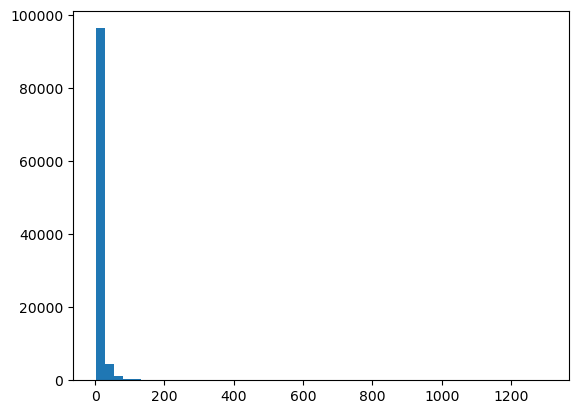

In [152]:
#Number of Reviews by user
temp = review_data.drop_duplicates('user_id')
plt.hist(temp.loc[:,'numReviewsByUser'], bins = 50)
plt.show()

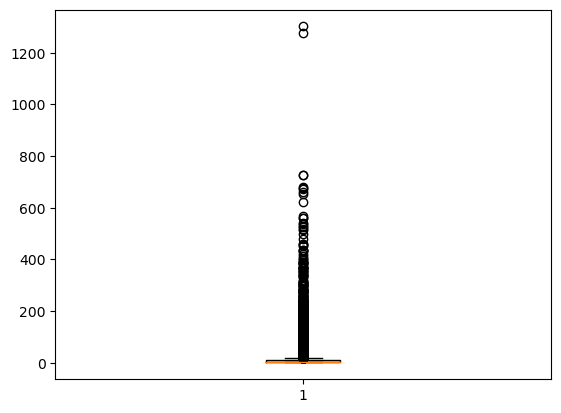

In [153]:
plt.boxplot(temp['numReviewsByUser'])
plt.show()

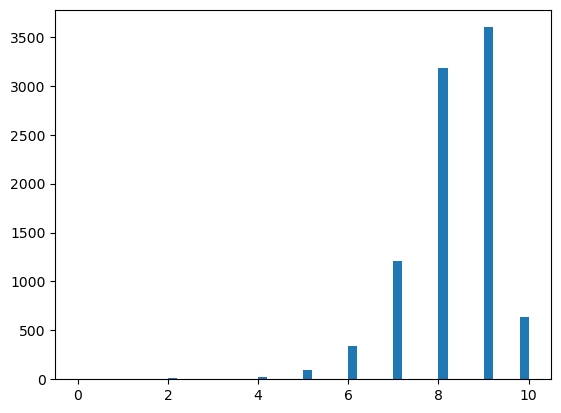

In [154]:
#average Rating
temp = review_data.drop_duplicates('product_id')
plt.hist(temp.loc[:,'averageRating'], bins = 50)
plt.show()

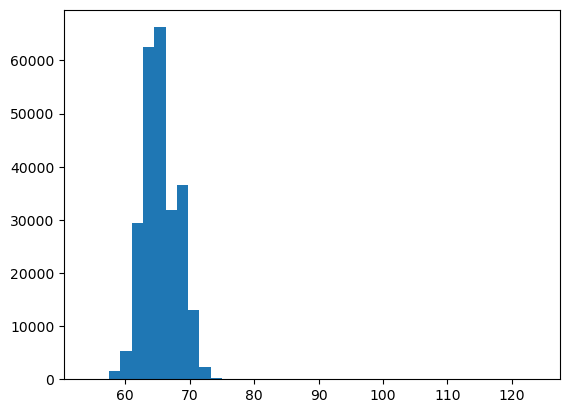

In [155]:
#height
plt.hist(review_data['heightInches'], bins = 40)
plt.show()

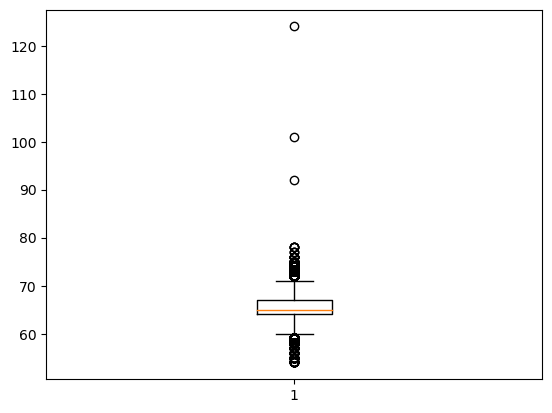

In [156]:
plt.boxplot(review_data['heightInches'])
plt.show()

In [157]:
h_idx = review_data.loc[review_data['heightInches'] > 75].index 
for idx in h_idx:
    review_data['heightInches'].iloc[idx] = review_data['heightInches'].median()

/var/folders/rx/0lw0w5ds7t36p51ggtr6fdr80000gn/T/ipykernel_95896/910608316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['heightInches'].iloc[idx] = review_data['heightInches'].median()


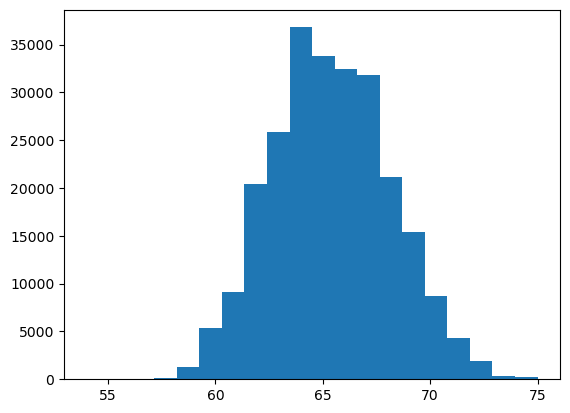

In [158]:
#height
plt.hist(review_data['heightInches'], bins = 20)
plt.show()

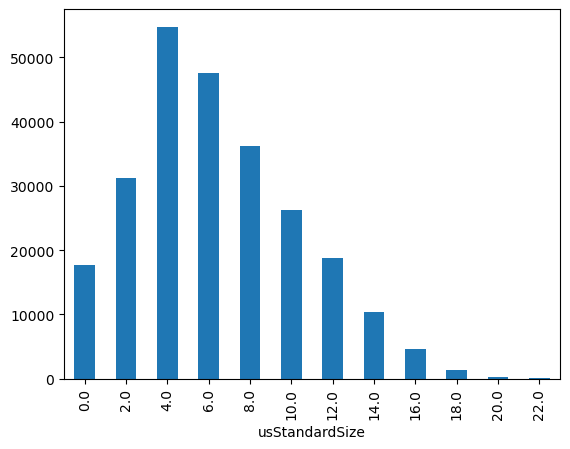

In [159]:
#US Standard sizes
us_size_grouped = review_data.groupby(['usStandardSize']).size()
us_size_grouped.plot(kind='bar')
plt.show()

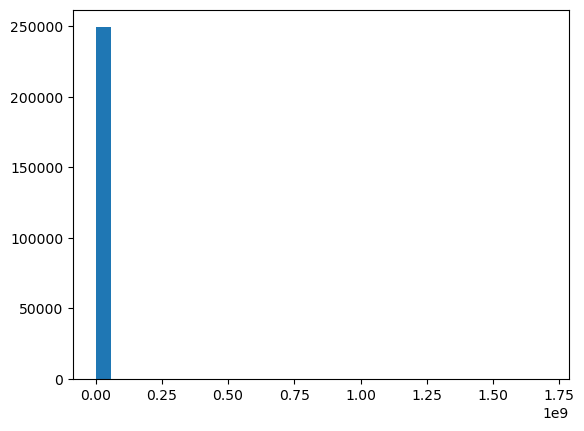

In [160]:
# Weight
plt.hist(review_data['weightPounds'], bins = 30)
plt.show()

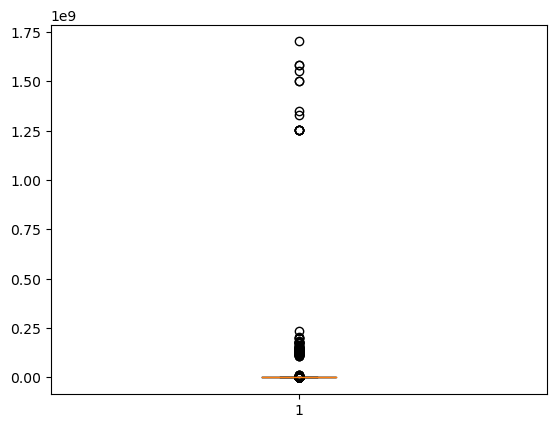

In [161]:
plt.boxplot(review_data['weightPounds'])
plt.show()

In [162]:
w_idx = review_data.loc[review_data['weightPounds'] > 300].index
for idx in w_idx:
    review_data['weightPounds'].iloc[idx] = review_data['weightPounds'].median()

/var/folders/rx/0lw0w5ds7t36p51ggtr6fdr80000gn/T/ipykernel_95896/3773554557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['weightPounds'].iloc[idx] = review_data['weightPounds'].median()


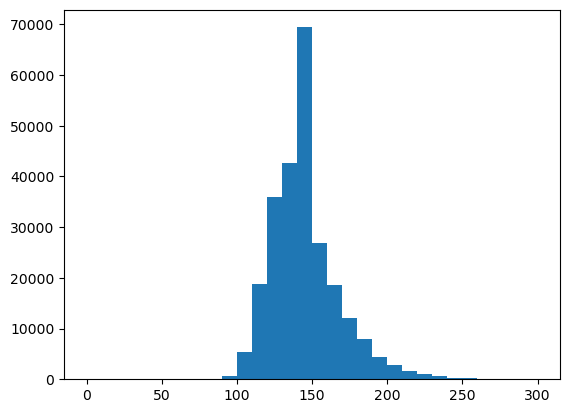

In [163]:
# Weight
plt.hist(review_data['weightPounds'], bins = 30)
plt.show()

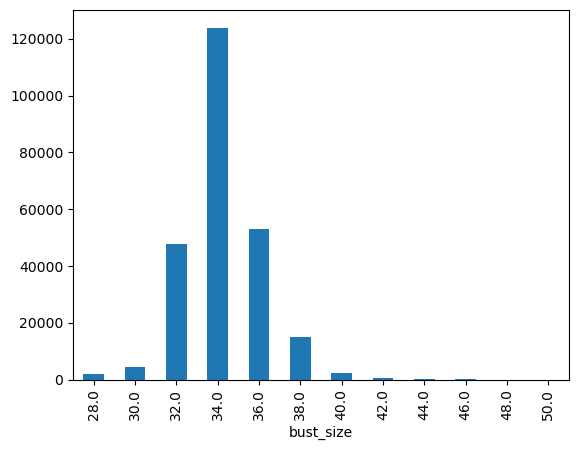

In [164]:
# Bust size
bust_size_grouped = review_data.groupby(['bust_size']).size()
bust_size_grouped.plot(kind = 'bar')
plt.show()

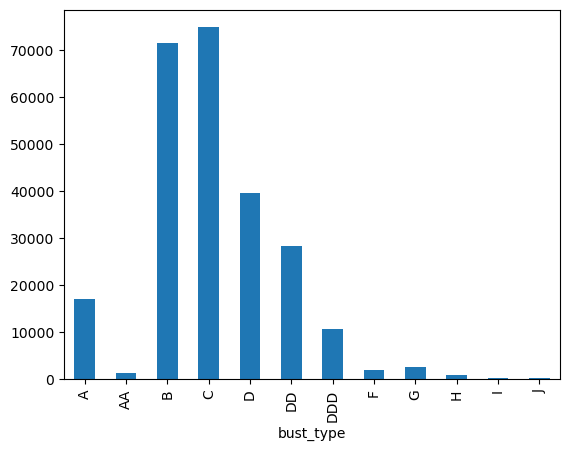

In [165]:
# Bust type
bust_type_grouped = review_data.groupby(['bust_type']).size()
bust_type_grouped.plot(kind = 'bar')
plt.show()

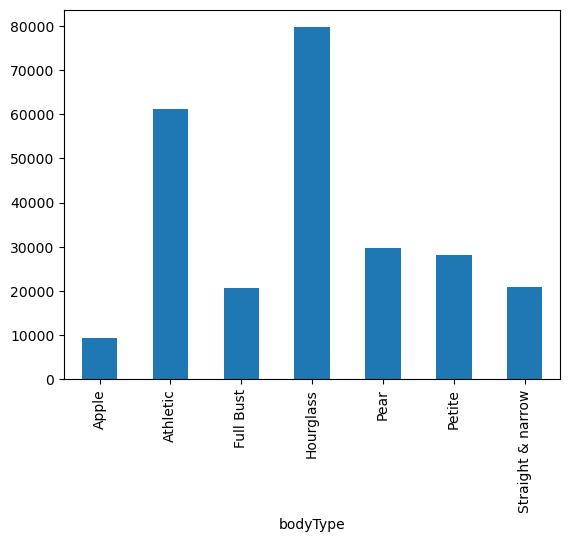

In [166]:
#Body type
body_type_grouped = review_data.groupby(['bodyType']).size()
body_type_grouped.plot(kind ='bar')
plt.show()

## Dummy Features

In [167]:
dummy_features = ['bodyType', 'fit', 'bust_type']

for ft in dummy_features:
    ft_dummies = pd.get_dummies(review_data[ft], prefix=ft)
    review_data = review_data.join(ft_dummies)
    review_data.drop(columns = [ft], inplace = True)

In [168]:
review_data.head()

,product_id,averageRating,countRatings,user_id,numReviewsByUser,heightInches,usStandardSize,weightPounds,caption,content,rating,reviewId,uploadedAt,product_img_link,bust_size,bodyType_Apple,bodyType_Athletic,bodyType_Full Bust,bodyType_Hourglass,bodyType_Pear,bodyType_Petite,bodyType_Straight & narrow,fit_Large,fit_Small,fit_True to Size,bust_type_A,bust_type_AA,bust_type_B,bust_type_C,bust_type_D,bust_type_DD,bust_type_DDD,bust_type_F,bust_type_G,bust_type_H,bust_type_I,bust_type_J
0,CRCR18,7.0,3,21194830,95,70.0,10.0,162.0,Feminine fit,This was a pretty dress. I brought it on vacat...,8,2939989,2024-04-08 21:10:51,https://pc-ap.rtrcdn.com/productimages/front/1...,36.0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,CRCR18,7.0,3,19471194,24,64.0,2.0,110.0,Team RTR Review,"A beautiful, easy vacation dress! Unfortunatel...",8,2927834,2024-03-25 19:28:00,https://pc-ap.rtrcdn.com/productimages/front/1...,34.0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,CRCR18,7.0,3,11604948,3,68.0,4.0,135.0,Cute but didn’t wear,NaN,6,2933106,2024-04-01 18:39:47,https://pc-ap.rtrcdn.com/productimages/front/1...,32.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,ADAMC171,9.0,3,22091421,77,65.0,2.0,125.0,RTR Team Review,Loved this flowy and feminine dress from Adam ...,10,2933881,2024-04-02 16:15:40,https://pc-ap.rtrcdn.com/productimages/front/1...,34.0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,ADAMC171,9.0,3,22164997,17,70.0,2.0,120.0,Lovely,"Gorgeous dress, fits and feels great, extremel...",10,2940474,2024-04-09 14:18:33,https://pc-ap.rtrcdn.com/productimages/front/1...,32.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


# Collaborative Filtering

## Sparse Matrix of User Vectors

### User-Item attributes

#### Get unique users and products

In [169]:
all_users = review_data['user_id'].value_counts()
filter_ = all_users >= 3 # Filter users with at least these number of ratings
users = list(all_users[filter_].index)

all_products = review_data.loc[review_data['user_id'].isin(users), 'product_id'].value_counts()
products = list(all_products.index)

In [171]:
len(users)

22760

In [172]:
len(products)

9043

In [173]:
user_prod_ratings = review_data[['product_id', 'user_id','rating']]
user_prod_ratings.head()

,product_id,user_id,rating
0,CRCR18,21194830,8
1,CRCR18,19471194,8
2,CRCR18,11604948,6
3,ADAMC171,22091421,10
4,ADAMC171,22164997,10


#### Map users and products

In [174]:
user_mapping = {}
for i, user in enumerate(user_prod_ratings['user_id'].unique()):
    user_mapping[user] = i

In [175]:
product_mapping = {}
for i, product in enumerate(user_prod_ratings['product_id'].unique()):
    product_mapping[product] = i

In [115]:
with open('product_mapping' + '.pkl', 'wb') as f:
    pickle.dump(product_mapping, f)
f.close()

In [116]:
with open('user_mapping' + '.pkl', 'wb') as f:
    pickle.dump(user_mapping, f)
f.close()

In [176]:
#user_item_rating = data_coll.groupby(['user_id', 'product_id']).agg({'rating': 'mean'}).reset_index()
user_item_rating = user_prod_ratings.copy()

In [177]:
user_item_rating.head()

,product_id,user_id,rating
0,CRCR18,21194830,8
1,CRCR18,19471194,8
2,CRCR18,11604948,6
3,ADAMC171,22091421,10
4,ADAMC171,22164997,10


In [180]:
user_item_rating['product_id'] = user_item_rating['product_id'].map(product_mapping)
user_item_rating['user_id'] = user_item_rating['user_id'].map(user_mapping)
user_item_rating.head()

,product_id,user_id,rating
0,NaN,NaN,8
1,NaN,NaN,8
2,NaN,NaN,6
3,NaN,NaN,10
4,NaN,NaN,10


In [179]:
sparse_matrix_rating = user_item_rating.pivot(index = 'user_id', columns = 'product_id', values = 'rating').fillna(0)
sparse_matrix_rating

product_id  0     1     2     3     4     5     6     7     8     9     10    \
user_id                                                                        
0            8.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1            8.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2            6.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3            0.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4            0.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
102983       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102984       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102985       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102986       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102987       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

product_id  11    12    13    14    15    16    17    18    19    20    21    \
user_id                                                                        
0            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3            0.0  10.0   0.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
102983       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102984       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102985       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102986       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102987       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

product_id  22    23    24    25    26    27    28    29    30    31    32    \
user_id                                                                        
0            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0   
4            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
102983       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102984       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102985       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102986       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102987       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

product_id  33    34    35    36    37    38    39    40    41    42    43    \
user_id                                                                        
0            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3           10.0   0.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0  10.0   0.0   
4            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
102983       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102984       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
102985       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 

In [121]:
with open('sparse_matrix_rating' + '.pkl', 'wb') as f:
    pickle.dump(sparse_matrix_rating, f)
f.close()

## SVD on user-products-ratings sparse matrix

In [181]:
svd = TruncatedSVD(n_components=100, random_state = 0)

U = svd.fit_transform(sparse_matrix_rating)

In [182]:
sigma = svd.singular_values_
VT = svd.components_

In [183]:
predicted_ratings = U @ np.diag(sigma) @ VT

In [61]:
with open('predicted_ratings' + '.pkl', 'wb') as f:
    pickle.dump(predicted_ratings, f)
f.close()

In [184]:
mse = mean_squared_error(sparse_matrix_rating, predicted_ratings)
print('Mean-squared error between actual and predicted ratings: ', mse)

Mean-squared error between actual and predicted ratings:  16.96829575714354


In [ ]:
predicted_ratings

In [185]:
predicted_ratings_df = pd.DataFrame(predicted_ratings)
print('Predicted ratings dataframe size: ', predicted_ratings_df.shape)
predicted_ratings_df.head()

Predicted ratings dataframe size:  (102988, 9105)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,...,8606,8607,8608,8609,8610,8611,8612,8613,8614,8615,8616,8617,8618,8619,8620,8621,8622,8623,8624,8625,8626,8627,8628,8629,8630,8631,8632,8633,8634,8635,8636,8637,8638,8639,8640,8641,8642,8643,8644,8645,8646,8647,8648,8649,8650,8651,8652,8653,8654,8655,8656,8657,8658,8659,8660,8661,8662,8663,8664,8665,8666,8667,8668,8669,8670,8671,8672,8673,8674,8675,8676,8677,8678,8679,8680,8681,8682,8683,8684,8685,8686,8687,8688,8689,8690,8691,8692,8693,8694,8695,8696,8697,8698,8699,8700,8701,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711,8712,8713,8714,8715,8716,8717,8718,8719,8720,8721,8722,8723,8724,8725,8726,8727,8728,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738,8739,8740,8741,8742,8743,8744,8745,8746,8747,8748,8749,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764,8765,8766,8767,8768,8769,8770,8771,8772,8773,8774,8775,8776,8777,8778,8779,8780,8781,8782,8783,8784,8785,8786,8787,8788,8789,8790,8791,8792,8793,8794,8795,8796,8797,8798,8799,8800,8801,8802,8803,8804,8805,8806,8807,8808,8809,8810,8811,8812,8813,8814,8815,8816,8817,8818,8819,8820,8821,8822,8823,8824,8825,8826,8827,8828,8829,8830,8831,8832,8833,8834,8835,8836,8837,8838,8839,8840,8841,8842,8843,8844,8845,8846,8847,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857,8858,8859,8860,8861,8862,8863,8864,8865,8866,8867,8868,8869,8870,8871,8872,8873,8874,8875,8876,8877,8878,8879,8880,8881,8882,8883,8884,8885,8886,8887,8888,8889,8890,8891,8892,8893,8894,8895,8896,8897,8898,8899,8900,8901,8902,8903,8904,8905,8906,8907,8908,8909,8910,8911,8912,8913,8914,8915,8916,8917,8918,8919,8920,8921,8922,8923,8924,8925,8926,8927,8928,8929,8930,8931,8932,8933,8934,8935,8936,8937,8938,8939,8940,8941,8942,8943,8944,8945,8946,8947,8948,8949,8950,8951,8952,8953,8954,8955,8956,8957,8958,8959,8960,8961,8962,8963,8964,8965,8966,8967,8968,8969,8970,8971,8972,8973,8974,8975,8976,8977,8978,8979,8980,8981,8982,8983,8984,8985,8986,8987,8988,8989,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999,9000,9001,9002,9003,9004,9005,9006,9007,9008,9009,9010,9011,9012,9013,9014,9015,9016,9017,9018,9019,9020,9021,9022,9023,9024,9025,9026,9027

In [ ]:
predicted_ratings_df.iloc[0]

In [186]:
#reversed product_mapping dictionary
product_mapping_reversed = {value: key for key, value in product_mapping.items()}

In [187]:
def recommend(user_id, n):
    #locate the user from sparse matrix and get products that are unrated or 0
    user_mapping_val = user_mapping[user_id]
    user_unrated_prods = sparse_matrix_rating.columns[sparse_matrix_rating.iloc[user_mapping_val] == 0].tolist()
    
    unrated_approximations = predicted_ratings_df.iloc[user_mapping_val]
    unrated_approximations = unrated_approximations.iloc[user_unrated_prods].sort_values(ascending = False)
    unrated_approximations = unrated_approximations.to_frame(name = 'predicted_ratings')
    #print(unrated_approximations)
    product_list = unrated_approximations.index[:n].to_list()
    #print(product_list)
    
    recoms_product_ids = [product_mapping_reversed[key] for key in product_list if key in product_mapping_reversed]
    print(recoms_product_ids)
    return recoms_product_ids

In [ ]:
recommend(21194830,3)

['SAO22', 'XA27', 'FRIO71', 'JSK128', 'ROAM17']


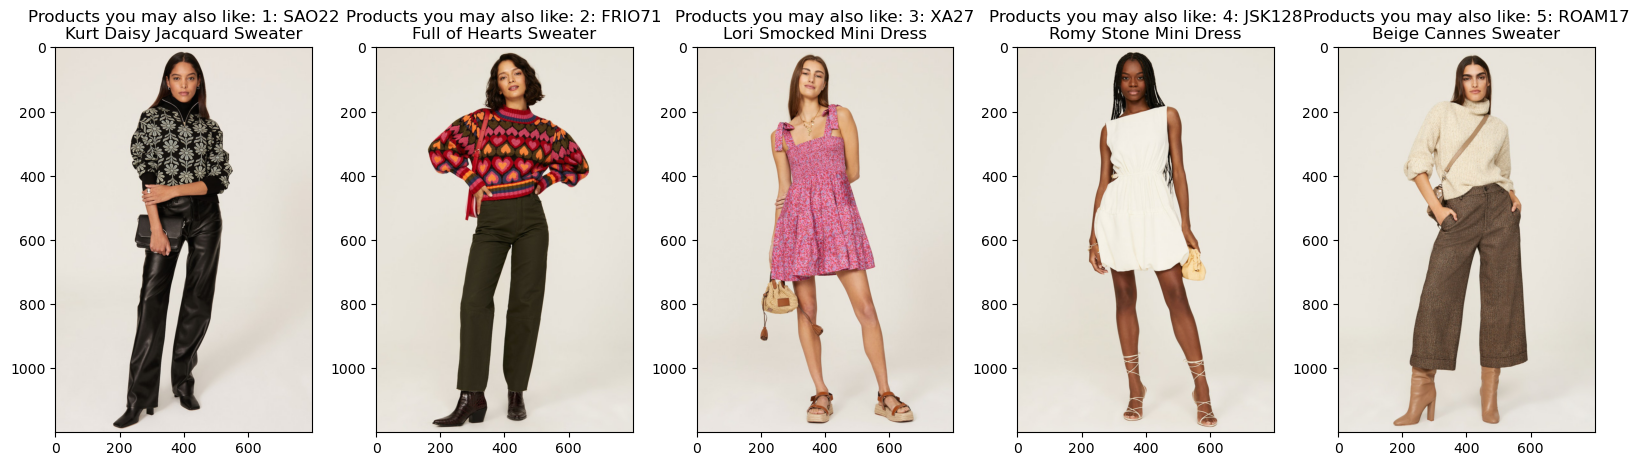

In [191]:
##get recommendations
for_user = 21194830
product_ids = recommend(for_user,5)
recommended_prods_df = all_product_data_list[all_product_data_list['product_id'].isin(product_ids)][['product_id', 'displayName', 'product_img_link']]
print_images(recommended_prods_df, 'Products you may also like: ')

## Let's see what the user has already rated

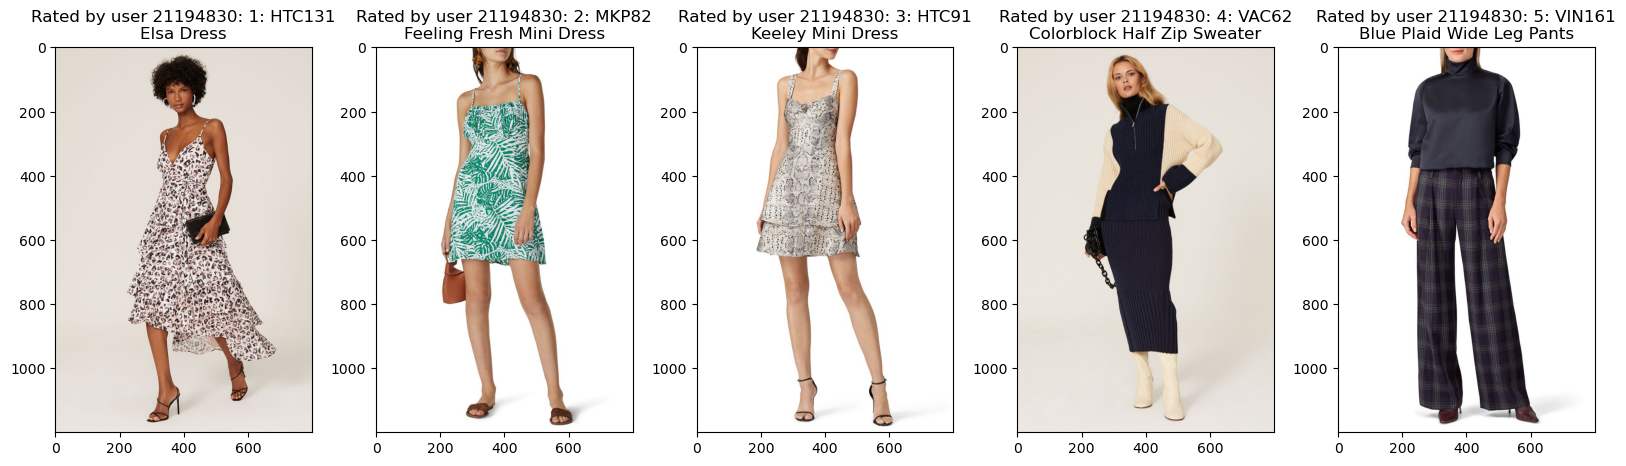

In [192]:
rated_prods_by_user = review_data[review_data['user_id'] == for_user][['product_id']]
rated_prods_by_user = pd.merge(rated_prods_by_user, all_product_data_list, on = 'product_id', how = 'left')[['product_id', 'displayName', 'product_img_link']]
print_images(rated_prods_by_user.tail(), f'Rated by user {for_user}: ')

In [190]:
def print_images(df, text_to_write):
  product_img_link = df['product_img_link'].values
  displayName = df['displayName'].values
  product = df['product_id'].values

  n = len(product_img_link)
  if n > 1:
    fig, axs = plt.subplots(1, n, figsize=(n*4, 5))
    i = 0
    for link, display_name, id_ in zip(product_img_link, displayName, product):
      if type(link) == str:
          response = requests.get(link)
          img = Image.open(BytesIO(response.content))
          axs[i].imshow(np.asarray(img))
          axs[i].set_title(str(text_to_write) + str(i+1) + ': ' + str(id_) + '\n' + str(display_name))
          # axs[i].axis('off')

      else:
        link = 'https://www.wildhareboca.com/wp-content/uploads/sites/310/2018/03/image-not-available-200x300.jpg'
        response = requests.get(link)
        img = Image.open(BytesIO(response.content))
        axs[i].imshow(np.asarray(img))
        axs[i].set_title(id_)
        # axs[i].axis('off')
      i+=1
    plt.show()

  else:
    fig, axs = plt.subplots(1, n, figsize=(n*4, 5))
    i = 0
    for link, display_name, id_ in zip(product_img_link, displayName, product):
      if type(link) == str:
          response = requests.get(link)
          img = Image.open(BytesIO(response.content))
          axs.imshow(np.asarray(img))
          axs.set_title(str(text_to_write) + str(i+1) + ': ' + str(id_) + '\n' + str(display_name))
          # axs[i].axis('off')

      else:
        link = 'https://www.wildhareboca.com/wp-content/uploads/sites/310/2018/03/image-not-available-200x300.jpg'
        response = requests.get(link)
        img = Image.open(BytesIO(response.content))
        axs.imshow(np.asarray(img))
        axs.set_title(id_)
        # axs[i].axis('off')
      i+=1
    plt.show()